In [120]:
library(ggplot2)
library(readr)
library(dplyr)
library(tidyr)
install.packages("reshape2")
library(reshape2)

CES_data <- read.table("CES21_Common_OUTPUT.tab", header = TRUE, sep = "\t")

CES_data <- CES_data %>%
    select(inputstate, pid7, pid3) |>
    rename(state = inputstate,
        party_id = pid7) |>
    filter(state != 98, state != 99) |>
    filter(party_id != 9, party_id != 98, party_id != 99) |>
    filter(pid3 %in% c(1, 2, 3)) |>
    select(-pid3)

anes_data <- read_csv("anes_timeseries_2020_csv_20220210.csv")

anes_data <- anes_data |>
    select(V201014b, V201231x) |>
    rename(state = V201014b,
          party_id = V201231x) |>
    filter(state != -1,    # Remove rows where state_id is -1
         !party_id %in% c(-8, -9))  # Remove rows where rep_placement is -8 or -9

survey_data <- bind_rows(anes_data, CES_data) |>
    filter(!is.na(state)) %>%
    arrange(state) |>
    filter(state != -9, state != -8, state != 86)

prop_data <- survey_data %>%
  mutate(state = as.numeric(state)) %>%
  group_by(state, party_id) %>%
  summarise(count = n(), .groups = 'drop') %>%
  mutate(total = sum(count), proportion = count / total) %>%
  ungroup()

entropy_data <- prop_data %>%
  group_by(state) %>%
  summarise(polarization_var = -sum(proportion * log2(proportion), na.rm = TRUE))

protest_data <- read_csv("ACLED_United_States.csv") |>
      select(event_id_cnty, year, admin1, event_type) |>
    mutate(admin1 = case_when(
    admin1 == "Alabama" ~ 1,
    admin1 == "Alaska" ~ 2,
    admin1 == "Arizona" ~ 4,
    admin1 == "Arkansas" ~ 5,
    admin1 == "California" ~ 6,
    admin1 == "Colorado" ~ 8,
    admin1 == "Connecticut" ~ 9,
    admin1 == "Delaware" ~ 10,
    admin1 == "Washington DC" ~ 11,
    admin1 == "Florida" ~ 12,
    admin1 == "Georgia" ~ 13,
    admin1 == "Hawaii" ~ 15,
    admin1 == "Idaho" ~ 16,
    admin1 == "Illinois" ~ 17,
    admin1 == "Indiana" ~ 18,
    admin1 == "Iowa" ~ 19,
    admin1 == "Kansas" ~ 20,
    admin1 == "Kentucky" ~ 21,
    admin1 == "Louisiana" ~ 22,
    admin1 == "Maine" ~ 23,
    admin1 == "Maryland" ~ 24,
    admin1 == "Massachusetts" ~ 25,
    admin1 == "Michigan" ~ 26,
    admin1 == "Minnesota" ~ 27,
    admin1 == "Mississippi" ~ 28,
    admin1 == "Missouri" ~ 29,
    admin1 == "Montana" ~ 30,
    admin1 == "Nebraska" ~ 31,
    admin1 == "Nevada" ~ 32,
    admin1 == "New Hampshire" ~ 33,
    admin1 == "New Jersey" ~ 34,
    admin1 == "New Mexico" ~ 35,
    admin1 == "New York" ~ 36,
    admin1 == "North Carolina" ~ 37,
    admin1 == "North Dakota" ~ 38,
    admin1 == "Ohio" ~ 39,
    admin1 == "Oklahoma" ~ 40,
    admin1 == "Oregon" ~ 41,
    admin1 == "Pennsylvania" ~ 42,
    admin1 == "Rhode Island" ~ 44,
    admin1 == "South Carolina" ~ 45,
    admin1 == "South Dakota" ~ 46,
    admin1 == "Tennessee" ~ 47,
    admin1 == "Texas" ~ 48,
    admin1 == "Utah" ~ 49,
    admin1 == "Vermont" ~ 50,
    admin1 == "Virginia" ~ 51,
    admin1 == "Washington" ~ 53,
    admin1 == "West Virginia" ~ 54,
    admin1 == "Wisconsin" ~ 55,
    admin1 == "Wyoming" ~ 56,
    TRUE ~ as.numeric(NA)  # Convert unknown states to NA (as numeric to match the expected type)
  ))

protest_data_summary <- protest_data %>%
  rename(state = admin1,
         event_id = event_id_cnty) %>%
  group_by(state) |>
  summarise(event_count = n()) |>
  filter(!is.na(state))

population_data <- read_csv("DECENNIALCD1182020.P1-2024-04-06T233703.csv") |>
  mutate(across(where(is.numeric), as.character))

population_data <- population_data %>%
  pivot_longer(
    cols = everything(),  
    names_to = "state", 
    values_to = "population"  
  )

population_data <- population_data %>%
  mutate(state = case_when(
          state == "Alabama" ~ 1,
          state == "Alaska" ~ 2,
          state == "Arizona" ~ 4,
          state == "Arkansas" ~ 5,
          state == "California" ~ 6,
          state == "Colorado" ~ 8,
          state == "Connecticut" ~ 9,
          state == "Delaware" ~ 10,
          state == "District of Columbia" ~ 11,
          state == "Florida" ~ 12,
          state == "Georgia" ~ 13,
          state == "Hawaii" ~ 15,
          state == "Idaho" ~ 16,
          state == "Illinois" ~ 17,
          state == "Indiana" ~ 18,
          state == "Iowa" ~ 19,
          state == "Kansas" ~ 20,
          state == "Kentucky" ~ 21,
          state == "Louisiana" ~ 22,
          state == "Maine" ~ 23,
          state == "Maryland" ~ 24,
          state == "Massachusetts" ~ 25,
          state == "Michigan" ~ 26,
          state == "Minnesota" ~ 27,
          state == "Mississippi" ~ 28,
          state == "Missouri" ~ 29,
          state == "Montana" ~ 30,
          state == "Nebraska" ~ 31,
          state == "Nevada" ~ 32,
          state == "New Hampshire" ~ 33,
          state == "New Jersey" ~ 34,
          state == "New Mexico" ~ 35,
          state == "New York" ~ 36,
          state == "North Carolina" ~ 37,
          state == "North Dakota" ~ 38,
          state == "Ohio" ~ 39,
          state == "Oklahoma" ~ 40,
          state == "Oregon" ~ 41,
          state == "Pennsylvania" ~ 42,
          state == "Rhode Island" ~ 44,
          state == "South Carolina" ~ 45,
          state == "South Dakota" ~ 46,
          state == "Tennessee" ~ 47,
          state == "Texas" ~ 48,
          state == "Utah" ~ 49,
          state == "Vermont" ~ 50,
          state == "Virginia" ~ 51,
          state == "Washington" ~ 53,
          state == "West Virginia" ~ 54,
          state == "Wisconsin" ~ 55,
          state == "Wyoming" ~ 56,
           TRUE ~ NA_integer_  
         ),
         population = if_else(state != "Total", as.numeric(population), NA_real_)) |>
  filter(!is.na(state) & state != "Total")  

protest_data_normalized <- protest_data_summary %>%
  left_join(population_data, by = "state") %>%
  mutate(protests_per_100k = (event_count / population) * 100000)


combined_data <- protest_data_normalized %>%
  select(state, protests_per_100k) %>%
  left_join(entropy_data, by = "state")
combined_data


The downloaded binary packages are in
	/var/folders/54/ttm7jj1s6zd6jgf805j54_cr0000gn/T//Rtmplfchj1/downloaded_packages


Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”
Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“number of items read is not a multiple of the number of columns”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 8280 Columns: 1771
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (20): version, V203001, V203054, V203056, V203078, V203079, V203080, V...
dbl (1751): V200001, V160001_orig, V200002, V200003, V200004, V200005, V2000...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 36793 Columns: 31
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (19): event_id_cnty, event_dat

state,protests_per_100k,polarization_var
<dbl>,<dbl>,<dbl>
1,7.284627,0.13333237
2,9.135645,0.02205297
4,6.180520,0.19872212
5,6.740773,0.08151470
6,13.905531,0.53408166
8,7.707344,0.16659249
9,17.887133,0.08675084
10,7.980217,0.03621034
12,8.561538,0.45382868


In [139]:
# Create a data frame in R with state names and unemployment rates
unemployment_data <- data.frame(
  state = c("North Dakota", "South Dakota", "Vermont", "Maryland", "Nebraska", 
            "New Hampshire", "Kansas", "Minnesota", "Utah", "Wyoming", "Iowa", 
            "Massachusetts", "Alabama", "Virginia", "Wisconsin", "Florida", "Georgia", 
            "Hawaii", "Mississippi", "South Carolina", "Idaho", "Missouri", "Tennessee", 
            "Maine", "Montana", "Pennsylvania", "Colorado", "Indiana", "North Carolina", 
            "Arkansas", "Oklahoma", "Ohio", "Michigan", "New Mexico", "Rhode Island", 
            "Texas", "Delaware", "Arizona", "Louisiana", "Oregon", "West Virginia", 
            "Kentucky", "New York", "Connecticut", "Alaska", "Washington", "Illinois", 
            "New Jersey", "District of Columbia", "Nevada", "California"),
  unemployment_rate = c(2.0, 2.1, 2.3, 2.4, 2.5, 
                                      2.6, 2.7, 2.7, 2.8, 2.8, 2.9, 
                                      2.9, 3.0, 3.0, 3.0, 3.1, 3.1, 
                                      3.1, 3.1, 3.1, 3.3, 3.3, 3.3, 
                                      3.4, 3.4, 3.4, 3.5, 3.5, 3.5, 
                                      3.6, 3.6, 3.7, 3.9, 3.9, 3.9, 
                                      3.9, 4.0, 4.1, 4.2, 4.2, 4.3, 
                                      4.4, 4.4, 4.5, 4.7, 4.7, 4.8, 
                                      4.8, 5.1, 5.2, 5.3)
)

poverty_data <- data.frame(
  state = c(
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado",
    "Connecticut", "Delaware", "District of Columbia", "Florida", "Georgia",
    "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky",
    "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota",
    "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire",
    "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota",
    "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina",
    "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia",
    "Washington", "West Virginia", "Wisconsin", "Wyoming"
  ),
  poverty_rate = c(
    16.3, 10.8, 12.9, 16.0, 12.3, 9.7, 10.1, 11.5, 16.8, 13.2, 14.2, 10.9, 10.8,
    12.1, 11.0, 11.0, 11.6, 16.3, 19.5, 11.2, 10.3, 10.4, 13.0, 9.3, 19.2, 12.8,
    12.0, 12.8, 10.5, 7.4, 10.2, 17.7, 14.0, 13.5, 10.9, 13.3, 15.4, 12.2, 12.0,
    12.1, 14.5, 11.9, 13.7, 14.2, 8.7, 10.2, 10.3, 9.9, 16.8, 10.8, 10.6
  )
)

income_data <- data.frame(
  state = c(
    "The United States", "Alabama", "Alaska", "Arizona", "Arkansas", "California", 
    "Colorado", "Connecticut", "Delaware", "District of Columbia", "Florida", "Georgia", 
    "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", 
    "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", 
    "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", 
    "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", 
    "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", 
    "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
  ),
  median_income = c(
    74580, 59910, 89740, 73450, 53980, 85300, 89930, 90730, 80750, 101700, 65370, 67730, 
    91010, 72580, 78020, 70030, 76320, 73040, 55880, 58330, 75160, 108200, 93550, 68990, 
    90390, 48610, 71520, 72980, 78360, 72330, 84970, 92340, 56420, 75910, 65070, 78720, 
    67520, 63440, 86780, 72210, 80650, 61770, 67180, 65380, 74640, 95800, 72190, 85170, 
    89430, 52460, 73330, 73090
  )
)

combined_data_3 <- merge(unemployment_data, poverty_data, by = "state")

economy_data <- merge(combined_data_3, income_data, by = "state")

max_income <- max(economy_data$median_income)

economy_data$normalized_income <- economy_data$median_income / max_income
economy_data$normalized_unemployment <- economy_data$unemployment_rate / 100
economy_data$normalized_poverty <- economy_data$poverty_rate / 100

economy_data$economic_index <- ((1 - economy_data$normalized_unemployment + 
                                 1 - economy_data$normalized_poverty + 
                                 economy_data$normalized_income) / 3) * 100
economy_data

state,unemployment_rate,poverty_rate,median_income,normalized_income,normalized_unemployment,normalized_poverty,economic_index
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alabama,3.0,16.3,59910,0.5536969,0.030,0.163,78.68990
Alaska,4.7,10.8,89740,0.8293900,0.047,0.108,89.14633
Arizona,4.1,12.9,73450,0.6788355,0.041,0.129,83.62785
Arkansas,3.6,16.0,53980,0.4988909,0.036,0.160,76.76303
California,5.3,12.3,85300,0.7883549,0.053,0.123,87.07850
Colorado,3.5,9.7,89930,0.8311460,0.035,0.097,89.97153
Connecticut,4.5,10.1,90730,0.8385397,0.045,0.101,89.75132
Delaware,4.0,11.5,80750,0.7463031,0.040,0.115,86.37677
District of Columbia,5.1,16.8,101700,0.9399261,0.051,0.168,90.69754


In [96]:
literacy_rate <- read_csv("us.-literacy-rates-by-state-2024.csv") |>
    select(-LiteracyRatesPercof4thGradersBelowBasicReadingLevel) |>
    rename(literacy_rate = LiteracyRatesPercofPopulationWithLowLiteracy)
 
dropout_rate <- read_csv("high-school-graduation-rates-by-state-2024.csv") |>
    rename(drop_out_rate = HighSchool)


bachelor_degree <- data.frame(
  state = c(
    "Alabama", "Alaska", "Arizona", "Arkansas", "California",
    "Colorado", "Connecticut", "Delaware", "District of Columbia",
    "Florida", "Georgia", "Hawaii", "Idaho", "Illinois",
    "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana",
    "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota",
    "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada",
    "New Hampshire", "New Jersey", "New Mexico", "New York",
    "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon",
    "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota",
    "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington",
    "West Virginia", "Wisconsin", "Wyoming"
  ),
  bachelor_degree = c(
    28.8, 30.6, 33.0, 25.4, 37.0, 45.9, 41.9, 36.5, 65.4, 34.3, 34.7,
    35.4, 32.3, 37.7, 29.6, 32.3, 35.6, 27.9, 27.1, 36.1, 43.8, 46.6,
    32.1, 39.1, 24.8, 32.2, 34.6, 34.7, 27.0, 41.3, 43.5, 30.5, 40.0,
    35.9, 31.8, 32.0, 28.5, 36.3, 35.1, 39.6, 32.6, 31.6, 31.1, 33.9,
    37.9, 44.2, 42.2, 39.5, 24.8, 33.2, 29.6
  ) 
)


com_data <- merge(dropout_rate, literacy_rate, by = "state") 

education_data <- merge(com_data, bachelor_degree, by = "state") 

education_data$education_index <- ((education_data$drop_out_rate) + 
                                  (education_data$bachelor_degree) + 
                                  (100 - education_data$literacy_rate)) /3


Rows: 50 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): state
dbl (2): LiteracyRatesPercofPopulationWithLowLiteracy, LiteracyRatesPercof4t...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 52 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): state
dbl (1): HighSchool

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [97]:
# Create a data frame with state names and diversity index values
diversity_data <- data.frame(
  state = c(
    "Hawaii", "California", "Nevada", "Maryland", "District of Columbia",
    "Texas", "New Jersey", "New York", "Georgia", "Florida", "New Mexico",
    "Alaska", "Arizona", "Virginia", "Illinois", "Delaware", "Oklahoma",
    "Louisiana", "North Carolina", "Washington", "Mississippi", "Connecticut",
    "South Carolina", "Alabama", "Colorado", "Massachusetts", "Arkansas",
    "Rhode Island", "Tennessee", "Oregon", "Kansas", "Michigan", "Pennsylvania",
    "Indiana", "Nebraska", "Missouri", "Utah", "Minnesota", "Ohio", "Wisconsin",
    "Idaho", "South Dakota", "Kentucky", "North Dakota", "Wyoming", "Iowa",
    "Montana", "New Hampshire", "Vermont", "West Virginia", "Maine"
  ),
  diversity_index = c(
    76.0, 69.7, 68.8, 67.3, 67.2, 67.0, 65.8, 65.8, 64.1, 64.1, 63.0,
    62.8, 61.5, 60.5, 60.3, 59.6, 59.5, 58.6, 57.9, 55.9, 55.9, 55.7,
    54.6, 53.1, 52.3, 51.6, 49.8, 49.4, 46.6, 46.1, 45.4, 45.2, 44.0, 41.3, 40.8, 40.8, 40.7, 40.5, 40.4, 37.0, 
    35.9, 35.6, 32.8, 32.6, 32.4, 30.8, 30.1, 23.6, 20.2, 20.2, 18.5
  )
)


In [131]:
# Create a data frame in R with each state and the direction they voted in the 2020 elections
election_results_2020 <- data.frame(
  state = c("Alabama", "Alaska", "Arizona", "Arkansas", "California",
    "Colorado", "Connecticut", "Delaware", "District of Columbia",
    "Florida", "Georgia", "Hawaii", "Idaho", "Illinois",
    "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana",
    "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota",
    "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada",
    "New Hampshire", "New Jersey", "New Mexico", "New York",
    "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon",
    "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota",
    "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington",
    "West Virginia", "Wisconsin", "Wyoming"),
  voted_2020 = c("Republican", "Republican", "Democrat", "Republican", "Democrat",
                 "Democrat", "Democrat", "Democrat", "Democrat", "Republican", "Democrat", "Democrat", "Republican",
                 "Democrat", "Republican", "Republican", "Republican", "Republican", "Republican",  "Democrat",  "Democrat",
                 "Democrat",  "Democrat",  "Democrat", "Republican", "Republican", "Republican", "Republican",
                "Democrat", "Democrat", "Democrat", "Democrat", "Democrat", "Republican", "Republican", "Republican",
                "Republican", "Democrat", "Democrat", "Democrat", "Republican", "Republican", "Republican", "Republican",
                "Republican", "Democrat", "Democrat", "Democrat", "Republican", "Democrat", "Republican")
)


head(election_results_2020)

,state,voted_2020
,<chr>,<chr>
1,Alabama,Republican
2,Alaska,Republican
3,Arizona,Democrat
4,Arkansas,Republican
5,California,Democrat
6,Colorado,Democrat


In [132]:
voter_turnout <- read_csv("Turnout_2022G_v1.1.csv") |>
    select(STATE, VAP_TURNOUT_RATE) |>
    rename(state = STATE, 
           turnout_rate = VAP_TURNOUT_RATE) |> 
    mutate(turnout_rate = as.numeric(gsub("%", "", turnout_rate))) |>
     slice(-1)
    
    

voter_turnout

Rows: 52 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): STATE, STATE_ABV, SOURCE, NONCITIZEN_PCT, VEP_TURNOUT_RATE, VAP_TUR...
num (8): TOTAL_BALLOTS_COUNTED, VAP, INELIGIBLE_PRISON, INELIGIBLE_PROBATION...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


state,turnout_rate
<chr>,<dbl>
Alabama,35.87
Alaska,47.92
Arizona,44.67
Arkansas,38.84
California,36.51
Colorado,54.76
Connecticut,44.79
Delaware,39.99
District of Columbia,37.54


In [138]:
comb_data <- merge(diversity_data, economy_data, by = "state") 
index_data_1 <- merge(comb_data, education_data, by = "state") |>
    select(state, diversity_index, education_index, economic_index)
index_data_2 <- merge(index_data_1, voter_turnout, by = "state")
index_data <- merge(index_data_2, election_results_2020, by = "state")

index_data <- index_data |>
  mutate(state = case_when(
          state == "Alabama" ~ 1,
          state == "Alaska" ~ 2,
          state == "Arizona" ~ 4,
          state == "Arkansas" ~ 5,
          state == "California" ~ 6,
          state == "Colorado" ~ 8,
          state == "Connecticut" ~ 9,
          state == "Delaware" ~ 10,
          state == "District of Columbia" ~ 11,
          state == "Florida" ~ 12,
          state == "Georgia" ~ 13,
          state == "Hawaii" ~ 15,
          state == "Idaho" ~ 16,
          state == "Illinois" ~ 17,
          state == "Indiana" ~ 18,
          state == "Iowa" ~ 19,
          state == "Kansas" ~ 20,
          state == "Kentucky" ~ 21,
          state == "Louisiana" ~ 22,
          state == "Maine" ~ 23,
          state == "Maryland" ~ 24,
          state == "Massachusetts" ~ 25,
          state == "Michigan" ~ 26,
          state == "Minnesota" ~ 27,
          state == "Mississippi" ~ 28,
          state == "Missouri" ~ 29,
          state == "Montana" ~ 30,
          state == "Nebraska" ~ 31,
          state == "Nevada" ~ 32,
          state == "New Hampshire" ~ 33,
          state == "New Jersey" ~ 34,
          state == "New Mexico" ~ 35,
          state == "New York" ~ 36,
          state == "North Carolina" ~ 37,
          state == "North Dakota" ~ 38,
          state == "Ohio" ~ 39,
          state == "Oklahoma" ~ 40,
          state == "Oregon" ~ 41,
          state == "Pennsylvania" ~ 42,
          state == "Rhode Island" ~ 44,
          state == "South Carolina" ~ 45,
          state == "South Dakota" ~ 46,
          state == "Tennessee" ~ 47,
          state == "Texas" ~ 48,
          state == "Utah" ~ 49,
          state == "Vermont" ~ 50,
          state == "Virginia" ~ 51,
          state == "Washington" ~ 53,
          state == "West Virginia" ~ 54,
          state == "Wisconsin" ~ 55,
          state == "Wyoming" ~ 56,
           TRUE ~ NA_integer_  
         ))

state_variable_data <- merge(combined_data, index_data, by = "state") |>
    select(state, voted_2020, everything()) 
    
state_variable_data
write.csv(state_variable_data, "state_variable_data.csv", row.names = FALSE)

state,voted_2020,protests_per_100k,polarization_var,diversity_index,education_index,economic_index,turnout_rate
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Republican,7.284627,0.13333237,53.1,63.93333,78.68990,35.87
2,Republican,9.135645,0.02205297,62.8,70.33333,89.14633,47.92
4,Democrat,6.180520,0.19872212,61.5,65.83333,83.62785,44.67
5,Republican,6.740773,0.08151470,49.8,63.16667,76.76303,38.84
6,Democrat,13.905531,0.53408166,69.7,64.16667,87.07850,36.51
8,Democrat,7.707344,0.16659249,52.3,73.80000,89.97153,54.76
9,Democrat,17.887133,0.08675084,55.7,71.86667,89.75132,44.79
10,Democrat,7.980217,0.03621034,59.6,68.93333,86.37677,39.99
12,Republican,8.561538,0.45382868,64.1,66.36667,81.37197,43.16


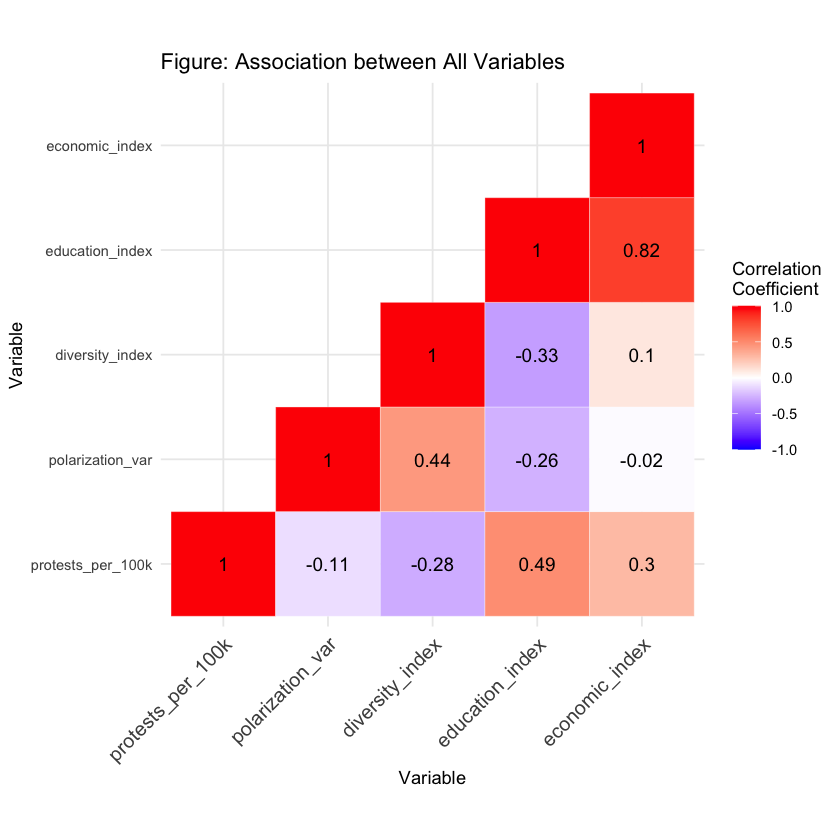

In [136]:
corr_matrix <- corr_matrix[!rownames(corr_matrix) %in% c("state", "voted_2020"), 
                           !colnames(corr_matrix) %in% c("state", "voted_2020")]

# Function to get the lower triangle of the correlation matrix
get_lower_tri <- function(corr_matrix) {
  corr_matrix[upper.tri(corr_matrix)] <- NA
  return(corr_matrix)
}

# Use the melt function from the reshape2 package to make the correlation matrix long
corr_mat <- melt(get_lower_tri(corr_matrix), na.rm = TRUE)

# Create the heatmap
ggplot(data = corr_mat, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                       midpoint = 0, limit = c(-1,1), space = "Lab", 
                       name="Correlation\nCoefficient") +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, vjust = 1, 
                                   size = 12, hjust = 1)) +
  geom_text(aes(x = Var1, y = Var2, label = round(value, 2)), color = "black", size = 4) +  # Adjust size if needed
  labs(title = "Figure: Association between All Variables", x = "Variable", y = "Variable") +
  coord_fixed()